## Contents
### 1. Importing libraries & data preprocessing
### 2. Application of Models
   #### 2.1. ANN Model
   #### 2.2. ANN Model with K-Fold and Cross Validation
### 3. Feature Importance

### 1. Importing libraries & data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.metrics import classification_report

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore', message='numpy.dtype size changed')

from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

from keras_visualizer import visualizer
from keras import models,layers
from keras.layers import Dropout
from keras.models import Model
from scikeras.wrappers import KerasClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.inspection import permutation_importance #use the other one
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import make_scorer

%matplotlib inline

In [2]:
df = pd.read_csv('../data/Churn_Modelling.csv',sep=',')

In [3]:
mean_age=round(df['Age'].mean())
df['Age'].fillna(value=mean_age,inplace=True)
df['HasCrCard'].mode()
df['HasCrCard'].fillna(value=1,inplace=True)
df['IsActiveMember'].mode()
df['IsActiveMember'].fillna(value=1,inplace=True)

In [4]:
products = [(df["NumOfProducts"]==1), (df["NumOfProducts"]==2), (df["NumOfProducts"]>2)]
values =["One product","Two products","More Than 2 products"]
df["Total_Products"] = np.select(products,values)
df.drop(columns='NumOfProducts',inplace=True)

In [5]:
balance = [(df["Balance"]==0), (df["Balance"]>0)]
values = ["Zero Balance","Cash in account"]
df["Account_Balance"] = np.select(balance, values)
df.drop(columns="Balance",inplace=True)

In [6]:
df=pd.get_dummies(df, columns=['Geography', 'Gender','Total_Products','Account_Balance'])

In [7]:
df

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Total_Products_More Than 2 products,Total_Products_One product,Total_Products_Two products,Account_Balance_Cash in account,Account_Balance_Zero Balance
0,1,15634602,Hargrave,619,42.0,2,1.0,1.0,101348.88,1,1,0,0,1,0,0,1,0,0,1
1,2,15647311,Hill,608,41.0,1,0.0,1.0,112542.58,0,0,0,1,1,0,0,1,0,1,0
2,3,15619304,Onio,502,42.0,8,1.0,0.0,113931.57,1,1,0,0,1,0,1,0,0,1,0
3,4,15701354,Boni,699,39.0,1,0.0,0.0,93826.63,0,1,0,0,1,0,0,0,1,0,1
4,5,15737888,Mitchell,850,43.0,2,1.0,1.0,79084.10,0,0,0,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,36.0,7,0.0,1.0,42085.58,1,1,0,0,1,0,0,1,0,0,1
9998,9999,15682355,Sabbatini,772,42.0,3,1.0,0.0,92888.52,1,0,1,0,0,1,0,0,1,1,0
9999,9999,15682355,Sabbatini,772,42.0,3,1.0,0.0,92888.52,1,0,1,0,0,1,0,0,1,1,0
10000,10000,15628319,Walker,792,28.0,4,1.0,0.0,38190.78,0,1,0,0,1,0,0,1,0,1,0


Since we are determining the important features that determine churn, both account balance and the total products are further broken down into extra features. 
For account balance, it is broken down to 2 categories. Whether they have cash in their account and zero balance in the account.
For the total products, they are broken down into 3 categories. They are 1 product, 2 products and more than 2 products.

In [8]:
X1=df.iloc[:,3:]
X1.drop(columns='Exited',inplace=True)

In [9]:
X1

,CreditScore,Age,Tenure,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Total_Products_More Than 2 products,Total_Products_One product,Total_Products_Two products,Account_Balance_Cash in account,Account_Balance_Zero Balance
0,619,42.0,2,1.0,1.0,101348.88,1,0,0,1,0,0,1,0,0,1
1,608,41.0,1,0.0,1.0,112542.58,0,0,1,1,0,0,1,0,1,0
2,502,42.0,8,1.0,0.0,113931.57,1,0,0,1,0,1,0,0,1,0
3,699,39.0,1,0.0,0.0,93826.63,1,0,0,1,0,0,0,1,0,1
4,850,43.0,2,1.0,1.0,79084.10,0,0,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,709,36.0,7,0.0,1.0,42085.58,1,0,0,1,0,0,1,0,0,1
9998,772,42.0,3,1.0,0.0,92888.52,0,1,0,0,1,0,0,1,1,0
9999,772,42.0,3,1.0,0.0,92888.52,0,1,0,0,1,0,0,1,1,0
10000,792,28.0,4,1.0,0.0,38190.78,1,0,0,1,0,0,1,0,1,0


In [10]:
y=df['Exited']

In [11]:
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X1),columns=X1.columns)

In [12]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=1)
X,y=smote.fit_resample(X,y)

In [13]:
X.shape

(15928, 16)

In [14]:
X.columns

Index(['CreditScore', 'Age', 'Tenure', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male',
       'Total_Products_More Than 2 products', 'Total_Products_One product',
       'Total_Products_Two products', 'Account_Balance_Cash in account',
       'Account_Balance_Zero Balance'],
      dtype='object')

In [15]:
X.rename(columns = {'CreditScore':'credit'}, inplace = True)
X.rename(columns = {'Age':'age'}, inplace = True)
X.rename(columns = {'Tenure':'tenure'}, inplace = True)
X.rename(columns = {'HasCrCard':'creditcard'}, inplace = True)
X.rename(columns = {'IsActiveMember':'active'}, inplace = True)
X.rename(columns = {'EstimatedSalary':'salary'}, inplace = True)
X.rename(columns = {'Geography_France':'France'}, inplace = True)
X.rename(columns = {'Geography_Germany':'Germany'}, inplace = True)
X.rename(columns = {'Geography_Spain':'Spain'}, inplace = True)
X.rename(columns = {'Gender_Female':'Female'}, inplace = True)
X.rename(columns = {'Gender_Male':'Male'}, inplace = True)
X.rename(columns = {'Total_Products_More Than 2 products':'>2_products'}, inplace = True)
X.rename(columns = {'Total_Products_One product':'1_product'}, inplace = True)
X.rename(columns = {'Total_Products_Two products':'2_products'}, inplace = True)
X.rename(columns = {'Account_Balance_Cash in account':'balance_in'}, inplace = True)
X.rename(columns = {'Account_Balance_Zero Balance':'0_balance'}, inplace = True)

In [16]:
X

,credit,age,tenure,creditcard,active,salary,France,Germany,Spain,Female,Male,>2_products,1_product,2_products,balance_in,0_balance
0,-0.326465,0.293500,-1.041728,0.646000,0.970443,0.022008,0.997404,-0.578813,-0.573733,1.095967,-1.095967,-0.183553,0.983342,-0.921117,-1.328637,1.328637
1,-0.440270,0.198136,-1.387530,-1.547987,0.970443,0.216663,-1.002603,-0.578813,1.742971,1.095967,-1.095967,-0.183553,0.983342,-0.921117,0.752651,-0.752651
2,-1.536934,0.293500,1.033084,0.646000,-1.030458,0.240817,0.997404,-0.578813,-0.573733,1.095967,-1.095967,5.448025,-1.016940,-0.921117,0.752651,-0.752651
3,0.501205,0.007408,-1.387530,-1.547987,-1.030458,-0.108802,0.997404,-0.578813,-0.573733,1.095967,-1.095967,-0.183553,-1.016940,1.085638,-1.328637,1.328637
4,2.063434,0.388863,-1.041728,0.646000,0.970443,-0.365171,-1.002603,-0.578813,1.742971,1.095967,-1.095967,-0.183553,0.983342,-0.921117,0.752651,-0.752651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15923,-0.743390,0.145128,1.225297,0.646000,-1.030458,-0.333656,0.997404,-0.578813,-0.573733,1.095967,-1.095967,-0.183553,0.983342,-0.921117,0.752651,-0.752651
15924,0.177703,-0.259076,1.396661,0.646000,-1.030458,-1.339684,-1.002603,1.727675,-0.573733,-0.912436,0.912436,-0.183553,0.983342,-0.921117,0.752651,-0.752651
15925,0.306957,-0.996485,-0.298058,0.646000,-1.030458,0.315906,-1.002603,1.727675,-0.573733,1.095967,-1.095967,-0.183553,0.983342,-0.921117,0.752651,-0.752651
15926,-1.252087,0.887164,-0.918985,0.646000,-0.320239,1.425313,-1.002603,1.727675,-0.573733,-0.912436,0.912436,-0.183553,-1.016940,1.085638,0.752651,-0.752651


In [24]:
#n_cols=X.shape[1]
#n_cols

16

### 2. Application of Models

#### 2.1. ANN Model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [19]:
def normalmodel():                                           

    #create model
    model=Sequential()
    
    #Input layer 1
    model.add(Dense(units=20,kernel_initializer='he_uniform',activation='relu',input_dim=16))
    #Dropout layer
    model.add(Dropout(0.2))
    #Input layer 2
    model.add(Dense(units=12,kernel_initializer='he_uniform',activation='relu'))
    #Input layer 3
    model.add(Dense(units=8,kernel_initializer='he_uniform',activation='relu'))
    #Input layer 4
    model.add(Dense(units=4,kernel_initializer='he_uniform',activation='relu'))
    #Output layer
    model.add(Dense(units=1,kernel_initializer='glorot_uniform',activation='sigmoid'))
    
    #Compile model
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'],weighted_metrics=[])
    
    return model

In [20]:
kf_classifier = KerasClassifier(model = normalmodel,validation_split=0.33,epochs=100,verbose=1,optimizer='adam',batch_size=10)

The neural network model we are going to use consists of 4 input layers and 1 dropout layer. It is a sequential model and start off with 20 nodes and decrease to 12, 8 and 4 before the output layer. A challenging portion is how do we determine the number of nodes and hidden layers. Usually, models start out with plenty of nodes in their first layer, 100 for example. The reason being is that in the first layer, performance generally increase the more nodes there are. Subsequently, in the next input layers, the nodes are heavily reduced. Since we have 16 features, an ideal number of nodes to start of is 20.  A dropout layer is added to prevent overfitting. It will randomly drop certain nodes for selection for the next input layer. A dropout layer of 0.2 means that it drops 4 nodes, which means that after the dropout layer, 16 different nodes are being selected, which coincides with the number of features. In each subsequent layer, the number of nodes gradually decrease from 16 to 12 to 8 and finally to 4. Glorot uniform is used to keep the scale of the gradients similar for all the layers. The uniform scaling helps prevent fluctuations in the gradients, be in exploding or vanishing gradients. The he uniform is used to find good variance for the distribution from which the initial parameters are drawn. 

In [21]:
normkf=kf_classifier.fit(X_train,y_train)

Epoch 1/100
854/854 [==============================] - 3s 2ms/step - loss: 0.6026 - accuracy: 0.6759 - val_loss: 0.5234 - val_accuracy: 0.7420
Epoch 2/100
854/854 [==============================] - 2s 2ms/step - loss: 0.5237 - accuracy: 0.7396 - val_loss: 0.4948 - val_accuracy: 0.7555
Epoch 3/100
854/854 [==============================] - 2s 2ms/step - loss: 0.5039 - accuracy: 0.7534 - val_loss: 0.4855 - val_accuracy: 0.7629
Epoch 4/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4937 - accuracy: 0.7558 - val_loss: 0.4761 - val_accuracy: 0.7669
Epoch 5/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4829 - accuracy: 0.7637 - val_loss: 0.4697 - val_accuracy: 0.7710
Epoch 6/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4780 - accuracy: 0.7658 - val_loss: 0.4729 - val_accuracy: 0.7746
Epoch 7/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4736 - accuracy: 0.7696 - val_loss: 0.4637 - val_accuracy: 0.7760

Epoch 58/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4216 - accuracy: 0.8018 - val_loss: 0.4311 - val_accuracy: 0.8014
Epoch 59/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4205 - accuracy: 0.8043 - val_loss: 0.4315 - val_accuracy: 0.7986
Epoch 60/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4232 - accuracy: 0.8031 - val_loss: 0.4284 - val_accuracy: 0.8014
Epoch 61/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4245 - accuracy: 0.8009 - val_loss: 0.4302 - val_accuracy: 0.7995
Epoch 62/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4246 - accuracy: 0.8071 - val_loss: 0.4319 - val_accuracy: 0.7976
Epoch 63/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4256 - accuracy: 0.8027 - val_loss: 0.4313 - val_accuracy: 0.8000
Epoch 64/100
854/854 [==============================] - 2s 2ms/step - loss: 0.4280 - accuracy: 0.8011 - val_loss: 0.4327 - val_accuracy:

In [22]:
normkf_acc=normkf.score(X_test,y_test)
normkf_acc

319/319 [==============================] - 0s 943us/step


0.7919020715630886

In [23]:
y_pred_norm=normkf.predict(X_test)
y_pred_norm=(y_pred_norm>0.5)
y_pred_norm

319/319 [==============================] - 0s 1ms/step


array([False, False, False, ...,  True,  True,  True])

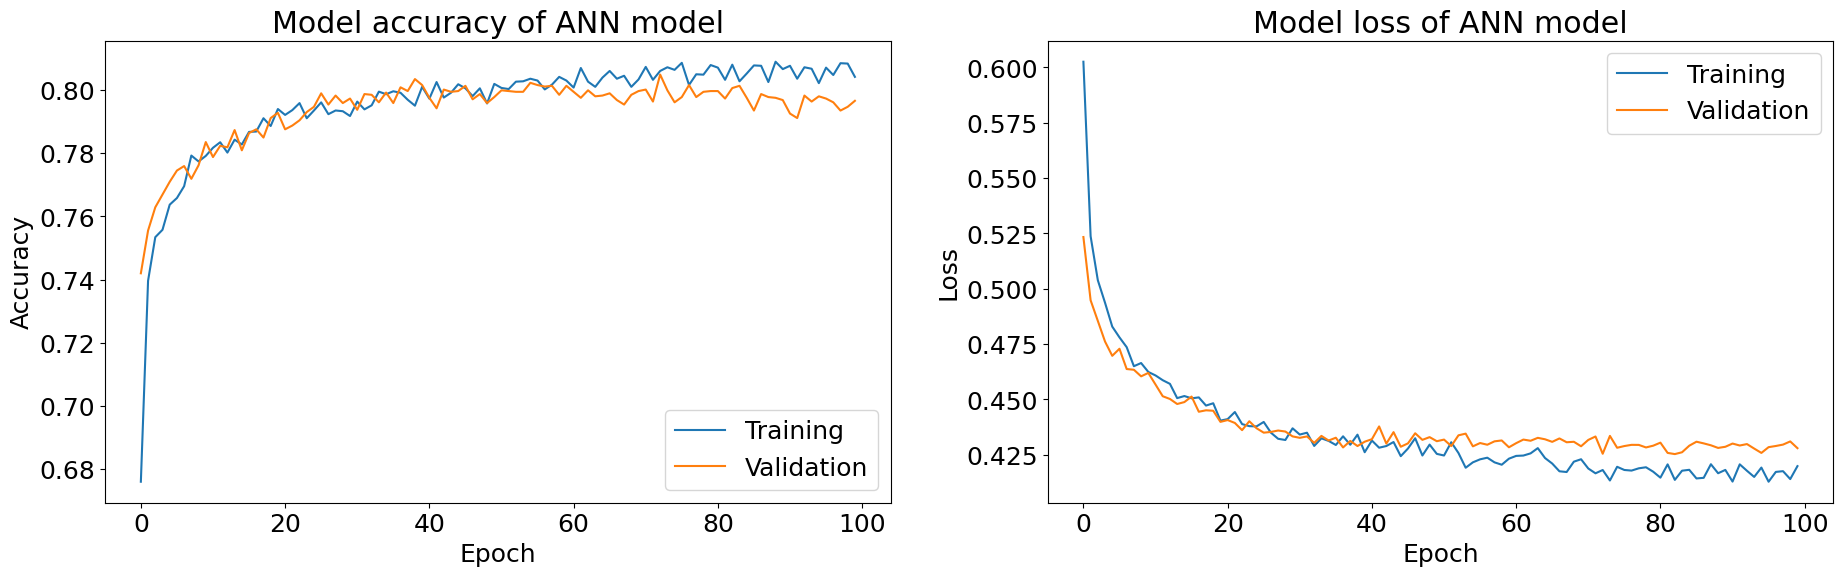

In [45]:
# Plotting of accuracy and loss of model
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(normkf.history_['accuracy'], label = 'Training')
ax[0].plot(normkf.history_['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy of ANN model')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(normkf.history_['loss'], label = 'Training')
ax[1].plot(normkf.history_['val_loss'], label = 'Validation')
ax[1].set_title('Model loss of ANN model')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

All the ANN models are being run with 100 epochs with a batch size of 10 and adam optimizer. The reason why 100 epochs are used is to ensure that the training and validation accuracy remain relatively similar, which means that it isn't overfitting or underfitting. There was an attempt to increase the number of epochs from 100 to 200 and higher values, but there is not much significant difference when compared to 100 epochs.

In [24]:
lrmodel = LogisticRegression()
# Fit Model
lrmodel.fit(X_train,y_train)
#print(f"intercept: {model.intercept_}")
#print(f"slope: {model.coef_}")
# Score
y_pred = lrmodel.predict(X_test)
acc_score =accuracy_score(y_test,y_pred) #acc and normal score are the same
print(acc_score)
test_score=lrmodel.score(X_test,y_test)
print(test_score)
train_score=lrmodel.score(X_train,y_train)
print(train_score)

0.7539234149403641
0.7539234149403641
0.7581227436823105


319/319 [==============================] - 0s 905us/step


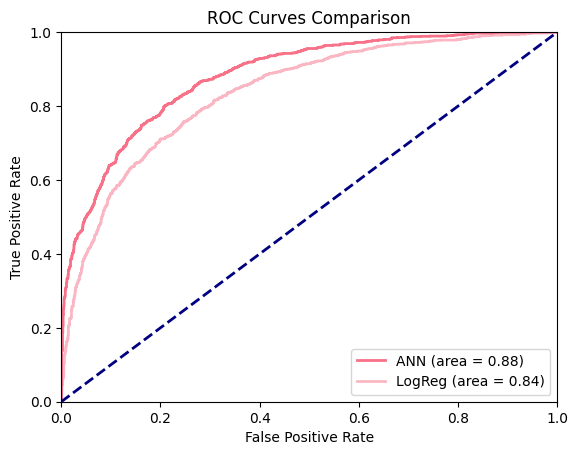

In [25]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
predsnorm = normkf.predict_proba(X_test)[:,1]
predslr = lrmodel.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fprnorm, tprnorm, _ = metrics.roc_curve(y_test, predsnorm)
fprlr, tprlr, _ = metrics.roc_curve(y_test, predslr)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_aucnorm = metrics.auc(fprnorm, tprnorm)
roc_auclr = metrics.auc(fprlr, tprlr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fprnorm, tprnorm, color='#f77189', lw = lw, label = 'ANN (area = %0.2f)' % roc_aucnorm)
plt.plot(fprlr, tprlr, color='#f77189',alpha=0.5, lw = lw, label = 'LogReg (area = %0.2f)' % roc_auclr)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc = "lower right")
plt.show()

Logistic Regression is used as a comparison with the ANN model. It can be observed that the ANN model has a better AUC and performed better than the Logistic Regression model.

#### 2.2. ANN Model with K-Fold and Cross Validation

In [28]:
%%time
kfold = KFold(n_splits=10)
scoring = ['accuracy', 'precision', 'recall', 'f1']
results = cross_validate(estimator=kf_classifier, X=X_train, y=y_train, scoring=scoring, cv=kfold, return_train_score=True, return_estimator=True)

Epoch 1/100
769/769 [==============================] - 3s 2ms/step - loss: 0.5866 - accuracy: 0.6817 - val_loss: 0.4997 - val_accuracy: 0.7466
Epoch 2/100
769/769 [==============================] - 2s 2ms/step - loss: 0.5037 - accuracy: 0.7541 - val_loss: 0.4824 - val_accuracy: 0.7593
Epoch 3/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4946 - accuracy: 0.7598 - val_loss: 0.4735 - val_accuracy: 0.7686
Epoch 4/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4839 - accuracy: 0.7628 - val_loss: 0.4682 - val_accuracy: 0.7736
Epoch 5/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4778 - accuracy: 0.7671 - val_loss: 0.4740 - val_accuracy: 0.7678
Epoch 6/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4735 - accuracy: 0.7728 - val_loss: 0.4688 - val_accuracy: 0.7728
Epoch 7/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4683 - accuracy: 0.7726 - val_loss: 0.4643 - val_accuracy: 0.7762

Epoch 58/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4204 - accuracy: 0.8002 - val_loss: 0.4346 - val_accuracy: 0.7989
Epoch 59/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4192 - accuracy: 0.7994 - val_loss: 0.4340 - val_accuracy: 0.7979
Epoch 60/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4193 - accuracy: 0.8020 - val_loss: 0.4327 - val_accuracy: 0.7968
Epoch 61/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4198 - accuracy: 0.8010 - val_loss: 0.4348 - val_accuracy: 0.7955
Epoch 62/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4182 - accuracy: 0.8027 - val_loss: 0.4346 - val_accuracy: 0.7947
Epoch 63/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4159 - accuracy: 0.8028 - val_loss: 0.4344 - val_accuracy: 0.7984
Epoch 64/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4168 - accuracy: 0.7982 - val_loss: 0.4332 - val_accuracy:

Epoch 71/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4299 - accuracy: 0.7937 - val_loss: 0.4373 - val_accuracy: 0.7894
Epoch 72/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4303 - accuracy: 0.7932 - val_loss: 0.4403 - val_accuracy: 0.7913
Epoch 73/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4328 - accuracy: 0.7948 - val_loss: 0.4458 - val_accuracy: 0.7878
Epoch 74/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4298 - accuracy: 0.7933 - val_loss: 0.4436 - val_accuracy: 0.7884
Epoch 75/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4324 - accuracy: 0.7911 - val_loss: 0.4395 - val_accuracy: 0.7897
Epoch 76/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4283 - accuracy: 0.7986 - val_loss: 0.4419 - val_accuracy: 0.7902
Epoch 77/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4283 - accuracy: 0.7945 - val_loss: 0.4362 - val_accuracy:

Epoch 84/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4161 - accuracy: 0.8049 - val_loss: 0.4366 - val_accuracy: 0.7992
Epoch 85/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4152 - accuracy: 0.8039 - val_loss: 0.4321 - val_accuracy: 0.8008
Epoch 86/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4085 - accuracy: 0.8049 - val_loss: 0.4351 - val_accuracy: 0.7942
Epoch 87/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.8072 - val_loss: 0.4364 - val_accuracy: 0.7995
Epoch 88/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4136 - accuracy: 0.8020 - val_loss: 0.4308 - val_accuracy: 0.7958
Epoch 89/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4110 - accuracy: 0.8065 - val_loss: 0.4303 - val_accuracy: 0.7982
Epoch 90/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4140 - accuracy: 0.8022 - val_loss: 0.4307 - val_accuracy:

Epoch 97/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4127 - accuracy: 0.8033 - val_loss: 0.4449 - val_accuracy: 0.7923
Epoch 98/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4139 - accuracy: 0.8044 - val_loss: 0.4433 - val_accuracy: 0.7913
Epoch 99/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4171 - accuracy: 0.7993 - val_loss: 0.4479 - val_accuracy: 0.7886
Epoch 100/100
1147/1147 [==============================] - 1s 788us/step
Epoch 1/100
769/769 [==============================] - 2s 2ms/step - loss: 0.6348 - accuracy: 0.6445 - val_loss: 0.5843 - val_accuracy: 0.7181
Epoch 2/100
769/769 [==============================] - 1s 2ms/step - loss: 0.5693 - accuracy: 0.7302 - val_loss: 0.5338 - val_accuracy: 0.7620
Epoch 3/100
769/769 [==============================] - 1s 2ms/step - loss: 0.5397 - accuracy: 0.7520 - val_loss: 0.5147 - val_accuracy: 0.7664
Epoch 4/100
769/769 [==============================] - 1s 2ms/step

769/769 [==============================] - 2s 2ms/step - loss: 0.4602 - accuracy: 0.7795 - val_loss: 0.4533 - val_accuracy: 0.7905
Epoch 10/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4583 - accuracy: 0.7794 - val_loss: 0.4480 - val_accuracy: 0.7918
Epoch 11/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4603 - accuracy: 0.7787 - val_loss: 0.4488 - val_accuracy: 0.7871
Epoch 12/100
769/769 [==============================] - 3s 3ms/step - loss: 0.4506 - accuracy: 0.7846 - val_loss: 0.4454 - val_accuracy: 0.7878
Epoch 13/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4525 - accuracy: 0.7846 - val_loss: 0.4467 - val_accuracy: 0.7894
Epoch 14/100
769/769 [==============================] - 3s 4ms/step - loss: 0.4464 - accuracy: 0.7885 - val_loss: 0.4433 - val_accuracy: 0.7886
Epoch 15/100
769/769 [==============================] - 3s 4ms/step - loss: 0.4517 - accuracy: 0.7848 - val_loss: 0.4434 - val_accuracy: 0.7900
Epoch

Epoch 66/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4211 - accuracy: 0.7972 - val_loss: 0.4350 - val_accuracy: 0.7968
Epoch 67/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4180 - accuracy: 0.8022 - val_loss: 0.4312 - val_accuracy: 0.7947
Epoch 68/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4182 - accuracy: 0.7984 - val_loss: 0.4342 - val_accuracy: 0.7955
Epoch 69/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4195 - accuracy: 0.8022 - val_loss: 0.4337 - val_accuracy: 0.7968
Epoch 70/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4206 - accuracy: 0.7984 - val_loss: 0.4378 - val_accuracy: 0.8005
Epoch 71/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4151 - accuracy: 0.8012 - val_loss: 0.4325 - val_accuracy: 0.7974
Epoch 72/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4174 - accuracy: 0.7999 - val_loss: 0.4340 - val_accuracy:

Epoch 79/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4214 - accuracy: 0.7996 - val_loss: 0.4334 - val_accuracy: 0.7984
Epoch 80/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4245 - accuracy: 0.7977 - val_loss: 0.4353 - val_accuracy: 0.8008
Epoch 81/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4239 - accuracy: 0.7983 - val_loss: 0.4337 - val_accuracy: 0.7987
Epoch 82/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4242 - accuracy: 0.7972 - val_loss: 0.4370 - val_accuracy: 0.8008
Epoch 83/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4229 - accuracy: 0.8036 - val_loss: 0.4348 - val_accuracy: 0.8029
Epoch 84/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4194 - accuracy: 0.8006 - val_loss: 0.4384 - val_accuracy: 0.8034
Epoch 85/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4239 - accuracy: 0.7980 - val_loss: 0.4354 - val_accuracy:

Epoch 92/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4170 - accuracy: 0.8002 - val_loss: 0.4306 - val_accuracy: 0.7902
Epoch 93/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4197 - accuracy: 0.7954 - val_loss: 0.4314 - val_accuracy: 0.7905
Epoch 94/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4202 - accuracy: 0.8046 - val_loss: 0.4335 - val_accuracy: 0.7908
Epoch 95/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4195 - accuracy: 0.7997 - val_loss: 0.4298 - val_accuracy: 0.7939
Epoch 96/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4149 - accuracy: 0.7981 - val_loss: 0.4332 - val_accuracy: 0.7939
Epoch 97/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4219 - accuracy: 0.7984 - val_loss: 0.4349 - val_accuracy: 0.7934
Epoch 98/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4201 - accuracy: 0.7949 - val_loss: 0.4364 - val_accuracy:

769/769 [==============================] - 2s 2ms/step - loss: 0.4881 - accuracy: 0.7610 - val_loss: 0.4710 - val_accuracy: 0.7770
Epoch 5/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4869 - accuracy: 0.7662 - val_loss: 0.4655 - val_accuracy: 0.7757
Epoch 6/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4794 - accuracy: 0.7691 - val_loss: 0.4641 - val_accuracy: 0.7812
Epoch 7/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4759 - accuracy: 0.7686 - val_loss: 0.4577 - val_accuracy: 0.7799
Epoch 8/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4697 - accuracy: 0.7714 - val_loss: 0.4597 - val_accuracy: 0.7828
Epoch 9/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4666 - accuracy: 0.7747 - val_loss: 0.4568 - val_accuracy: 0.7802
Epoch 10/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4654 - accuracy: 0.7709 - val_loss: 0.4512 - val_accuracy: 0.7828
Epoch 11/1

769/769 [==============================] - 2s 2ms/step - loss: 0.4219 - accuracy: 0.7964 - val_loss: 0.4279 - val_accuracy: 0.8074
Epoch 62/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4250 - accuracy: 0.7960 - val_loss: 0.4299 - val_accuracy: 0.8034
Epoch 63/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4208 - accuracy: 0.7953 - val_loss: 0.4307 - val_accuracy: 0.8050
Epoch 64/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4227 - accuracy: 0.7951 - val_loss: 0.4354 - val_accuracy: 0.8042
Epoch 65/100
769/769 [==============================] - 2s 2ms/step - loss: 0.4230 - accuracy: 0.7947 - val_loss: 0.4357 - val_accuracy: 0.8013
Epoch 66/100
769/769 [==============================] - 2s 3ms/step - loss: 0.4217 - accuracy: 0.7958 - val_loss: 0.4332 - val_accuracy: 0.7968
Epoch 67/100
769/769 [==============================] - 1s 2ms/step - loss: 0.4240 - accuracy: 0.7964 - val_loss: 0.4301 - val_accuracy: 0.8024
Epoch

For the ANN model with K-Fold and Cross Validation, the Keras classifier wrapper is used to wrap the ANN model before it is being cross validated. It ran with 100 epochs and a total of 10 splits. This means that it ran a total of 1000 iterations. 

In [32]:
kfold_model=results['estimator'][2]
#results['estimator'][2] and kfnorm gives the same type of output

In [33]:
# accuracy
kfold_model.score(X_test, y_test)

319/319 [==============================] - 0s 1ms/step


0.7887633396107973

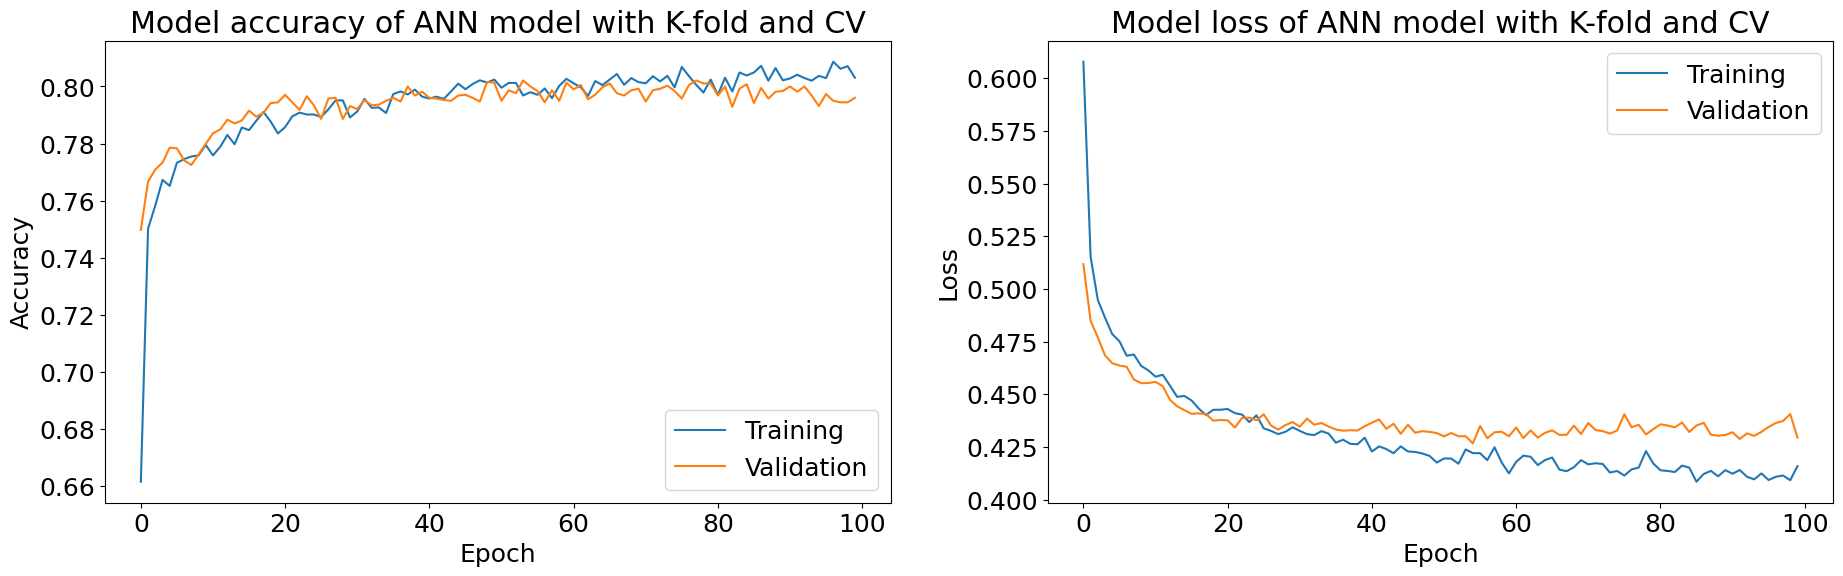

In [48]:
# insert code here
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(kfold_model.history_['accuracy'], label = 'Training')
ax[0].plot(kfold_model.history_['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy of ANN model with K-fold and CV')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(kfold_model.history_['loss'], label = 'Training')
ax[1].plot(kfold_model.history_['val_loss'], label = 'Validation')
ax[1].set_title('Model loss of ANN model with K-fold and CV')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

For the ANN model with K-fold and CV, the accuracy is more noisy. However, the training and validation accuracy still remains relatively similar.

319/319 [==============================] - 0s 987us/step


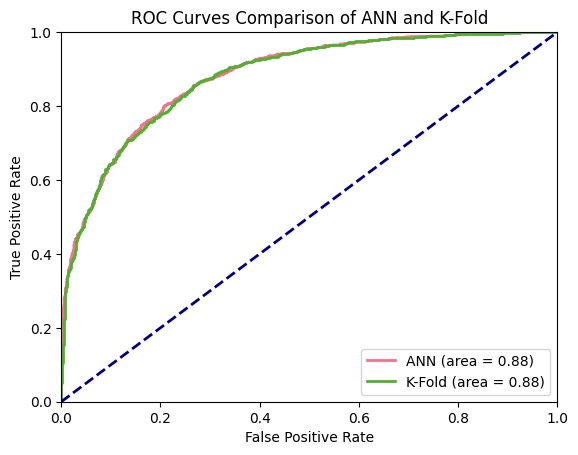

In [51]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
predsnorm = normkf.predict_proba(X_test)[:,1]
predskfold = kfold_model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fprnorm, tprnorm, _ = metrics.roc_curve(y_test, predsnorm)
fprkfold, tprkfold, _ = metrics.roc_curve(y_test, predskfold)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_aucnorm = metrics.auc(fprnorm, tprnorm)
roc_auckfold = metrics.auc(fprkfold, tprkfold)

# Plot the ROC Curve
plt.figure()
plt.rcParams.update({'font.size': 10})
lw = 2
plt.plot(fprnorm, tprnorm, color='#f77189', lw = lw, label = 'ANN (area = %0.2f)' % roc_aucnorm)
plt.plot(fprkfold, tprkfold, color='#50b131', lw = lw, label = 'K-Fold (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison of ANN and K-Fold')
plt.legend(loc = "lower right")
plt.show()

When comparing both ANN models, there is not much significant difference. Both models are relatively similar. If the models are ran with more epochs, it still will remain relatively similar. In conclusion, when using Neural Network, both ANN and ANN with K-fold and CV are relatively similar in appication. If the datasets are larger and more complex, it might be better to use K-fold and CV as running it over more splits ensures that it is more accurate. The downside to ANN with K-fold and CV is that it takes a longer time to run the models.

### 3. Feature Importance

In [52]:
X.columns

Index(['credit', 'age', 'tenure', 'creditcard', 'active', 'salary', 'France',
       'Germany', 'Spain', 'Female', 'Male', '>2_products', '1_product',
       '2_products', 'balance_in', '0_balance'],
      dtype='object')

In [62]:
annperm = permutation_importance(normkf, X_test, y_test, n_repeats=10, random_state=42)
annimportance=annperm.importances_mean

319/319 [==============================] - 0s 761us/step


The permutation importance function is used to determine the feature importance of the models. It will be ran twice, once with the ANN model and a second time with the ANN model with K-fold and CV. It is ran for a total of 10 times, and the mean of the coefficients are collected.

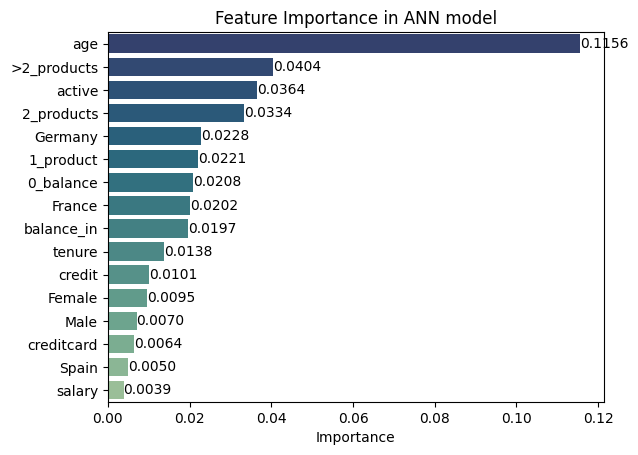

In [64]:
norm_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(annimportance)})
norm_feature_importance = norm_feature_importance.sort_values('Importance', ascending=False)


#dt_feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
ax=sns.barplot(x='Importance',y='Feature',data=norm_feature_importance,palette='crest_r')
plt.title('Feature Importance in ANN model')
plt.ylabel('')
#plt.legend(loc='lower right')
ax.bar_label(ax.containers[0],fmt='%.4f')

plt.show()

When determining which features have an impact on churn, it can be observed that age has the highest coefficients. The feature engineering that was done earlier to separate the product count into 3 different features all happened to have relatively high coefficients when compared to the rest.
As compared to Spain and France, Germany has the highest coefficients as well. This means that customers in Germany do have an increased chance of churning as compared to the other 2 countries.

In [65]:
kfoldperm = permutation_importance(kfold_model, X_test, y_test, n_repeats=10, random_state=42)
kfoldimportance = kfoldperm.importances_mean

319/319 [==============================] - 0s 935us/step


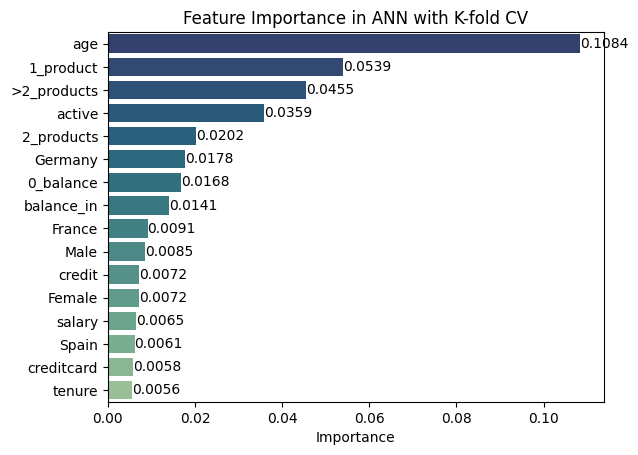

In [66]:
kf_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(kfoldimportance)})
kf_feature_importance = kf_feature_importance.sort_values('Importance', ascending=False)


#dt_feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
ax=sns.barplot(x='Importance',y='Feature',data=kf_feature_importance,palette='crest_r')
plt.title('Feature Importance in ANN with K-fold CV')
plt.ylabel('')
#plt.legend(loc='lower right')
ax.bar_label(ax.containers[0],fmt='%.4f')

plt.show()

For the feature importance in the ANN model with K-fold and CV, it is relatively similar to the ANN model. Age again has the highest coefficients. The number of products seemed to be very important as well.

To conclude, it can be observed that age of the customers does play a huge role in determining Churn.
As a solution, engaging customers through the right channel is important. Older customers prefer less of a technology reach, and more of a face to face interaction. For the younger generation, the opposite may be applied and a more technology focused approach may be applied. Based on the EDA, almost 40% of the customers are around the age of 40-49. A simple act of simplifying the banking experience for the older members will do a great deal in customer retention.

Regarding the product count, overall having a better product awareness helps to ensure that the customer sticks with the same banking institution. Placing importance in loyalty to customers will ensure customer retention, which in turn may help bring better awareness to the products the banks have to offer.

When looking at the 3 countries, Germany have a higher churn rate as compared to Spain and France. The banks can analyse the facilities and behaviour of how banks are being ran differently in Germany than the other 2 countries. Tax regulations or payment processing can be looked at and refined if there is any need.